Dans ce notebook on reteste les meilleurs algorithmes pour chacun des jeux de données dans le but d'**afficher des résultats explicables** (Arbres, feature importance plot).

## Traitement des données

In [80]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
from sklearn import metrics

In [56]:
def impute_nans(data):
    """Missing values imputation by creating a missing category"""
    missing_values_imp = SimpleImputer(strategy='constant', fill_value='missing')
    missing_cols = ['categorie_juridique_label', 'activite_principale_label', 'nom_raison_sociale', 'description',
                    'intitule', 'fondement_juridique_title']
    data[missing_cols] = missing_values_imp.fit_transform(data[missing_cols])
    return data

In [57]:
def aggregate_cat(data, cat_variables):
    """Aggregates less frequent categorical variables (less than 1%) [optional but improves perf most of the time]"""
    for variable in cat_variables:
        if data[variable].nunique() > 20:
            for category in data[variable].unique():
                if data[variable].value_counts()[category] / len(data) <= 0.01:
                    data.loc[data[variable] == category, variable] = 'Autre'
    return data

In [58]:
def preprocess_data(data_path,text_enc):
    """Returns X and y for a given dataset togheter with the adequate column transformer for a given text transformer"""
    data = pd.read_csv(data_path)
    data = data.drop(columns=['id', 'siret', 'categorie_juridique', 'activite_principale', 'instruction_comment',
                              'fondement_juridique_url'])
    data = impute_nans(data)
    cat_variables = ['target_api', 'categorie_juridique_label', 'activite_principale_label']
    data = aggregate_cat(data, cat_variables)
    text_col = ['nom_raison_sociale','intitule','fondement_juridique_title','description']
    data = remove_stopwords(data,text_col)
    one_hot_enc = OneHotEncoder(handle_unknown='ignore')
    label_enc = preprocessing.LabelEncoder()
    columns_trans = make_column_transformer((one_hot_enc, cat_variables), (text_enc, 'nom_raison_sociale'),
                                            (text_enc, 'intitule'),
                                            (text_enc, 'fondement_juridique_title'),
                                            (text_enc, 'description'))
    y = data['status'].values
    y = label_enc.fit_transform(y)
    X = data.drop(columns=['status'])
    return X,y,columns_trans

In [59]:
import nltk
from nltk.corpus import stopwords
def remove_stopwords(data,text_col):
    stopwords_list=stopwords.words('french')
    for word in ['de la','DE','DES']:
        stopwords_list.append(word)
    pat = r'\b(?:{})\b'.format('|'.join(stopwords_list))
    for col in text_col:
        data[col] = data[col].str.replace(pat, '')
    return data

## 1. Franceconnect

In [60]:
data_path = '../data_other/output_franceconnect.csv'

In [61]:
text_enc = TfidfVectorizer(ngram_range=(1,2))
X,y,columns_trans = preprocess_data(data_path,text_enc)

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [63]:
xgboost = XGBClassifier()

In [64]:
param_grid = {
   "xgbclassifier__objective": ["binary:logistic"],
   "xgbclassifier__eval_metric": ["logloss"],
   "xgbclassifier__eta": [0.05, 0.075, 0.1],
   "xgbclassifier__max_depth": [6],
   "xgbclassifier__min_child_weight": [1, 2],
   "xgbclassifier__subsample": [0.5, 1.0],
}

In [65]:
pipe = make_pipeline(columns_trans, xgboost)

In [66]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)

In [67]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['target_api',
                                                                          'categorie_juridique_label',
                                                                          'activite_principale_label']),
                                                                        ('tfidfvectorizer-1',
                                                                         TfidfVectorizer(ngram_range=(1,
                                                                                                      2)),
                                                                         'nom_raison_sociale'),
                   

## Prediction's results

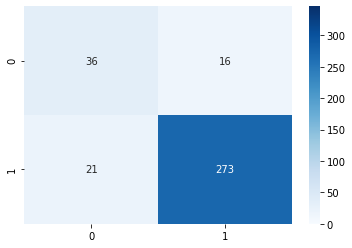

In [68]:
pred_xgboost = grid.predict(X_test)
confusion = confusion_matrix(y_test, pred_xgboost)
sns.heatmap(confusion, annot=True, vmin=0, vmax=len(y_test),cmap='Blues', fmt='g')
plt.show()

In [69]:
pred_logreg = grid.predict(X_test)
print(classification_report(y_test, pred_logreg))

              precision    recall  f1-score   support

           0       0.63      0.69      0.66        52
           1       0.94      0.93      0.94       294

    accuracy                           0.89       346
   macro avg       0.79      0.81      0.80       346
weighted avg       0.90      0.89      0.90       346



In [70]:
model= grid.best_estimator_.named_steps['xgbclassifier']

In [71]:
trasnf= grid.best_estimator_.named_steps['columntransformer']

In [72]:
feature_names=trasnf.get_feature_names()

In [19]:
#from xgboost import plot_importance
#import xgboost as xgb
#plot_importance(model,max_num_features=10,importance_type='gain')

## Explainability

### SHAP importance plot

In [73]:
import shap

In [74]:
explainer = shap.TreeExplainer(model)

In [75]:
shap_values = explainer.shap_values(trasnf.fit_transform(X_train))

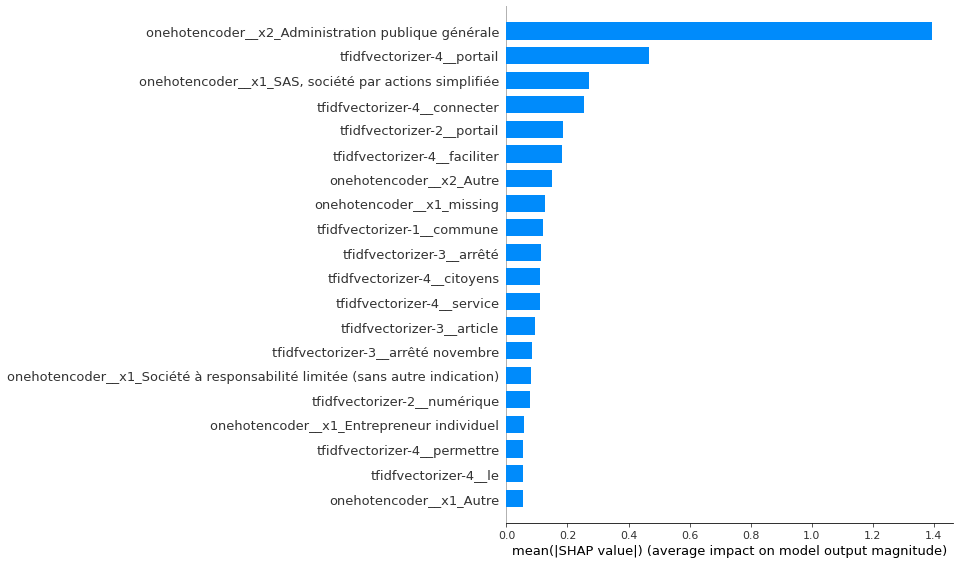

In [76]:
shap.summary_plot(shap_values, trasnf.fit_transform(X_train), plot_type="bar",feature_names=feature_names)

### SHAP decision plot

In [77]:
expected_value = explainer.expected_value

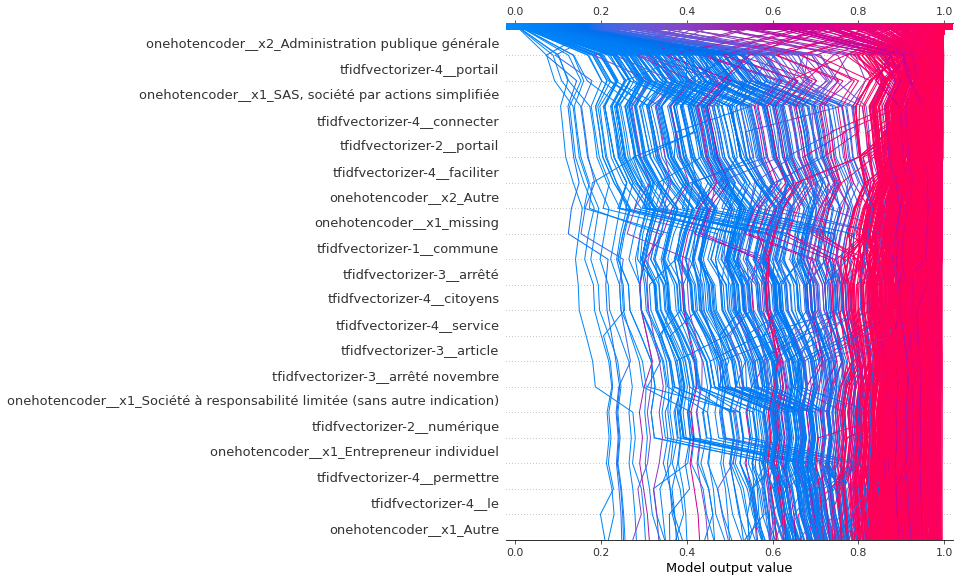

In [78]:
shap.decision_plot(expected_value, shap_values,  link='logit',feature_names=feature_names)

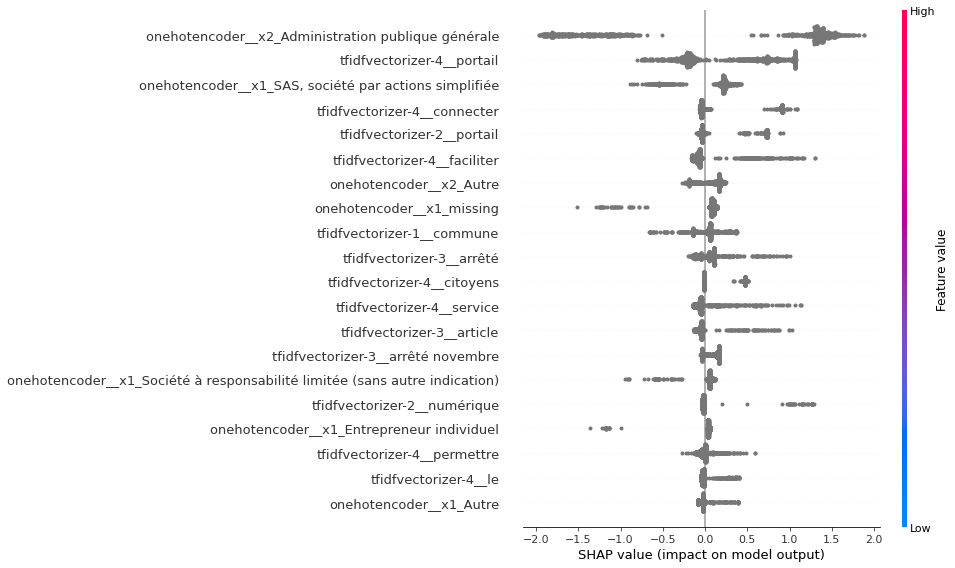

In [79]:
shap.summary_plot(shap_values, trasnf.fit_transform(X_train),feature_names=feature_names)

### ROC curve

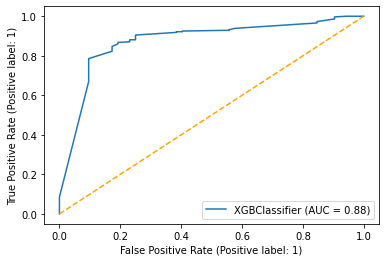

In [84]:
metrics.plot_roc_curve(model, trasnf.fit_transform(X_test), y_test)  
plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
plt.show()   

### Plot tree

### Xgboost tree

In [27]:
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tcategorical\n'.format(i, feat))
    outfile.close()

In [28]:
create_feature_map(feature_names)

In [29]:
from xgboost import plot_tree

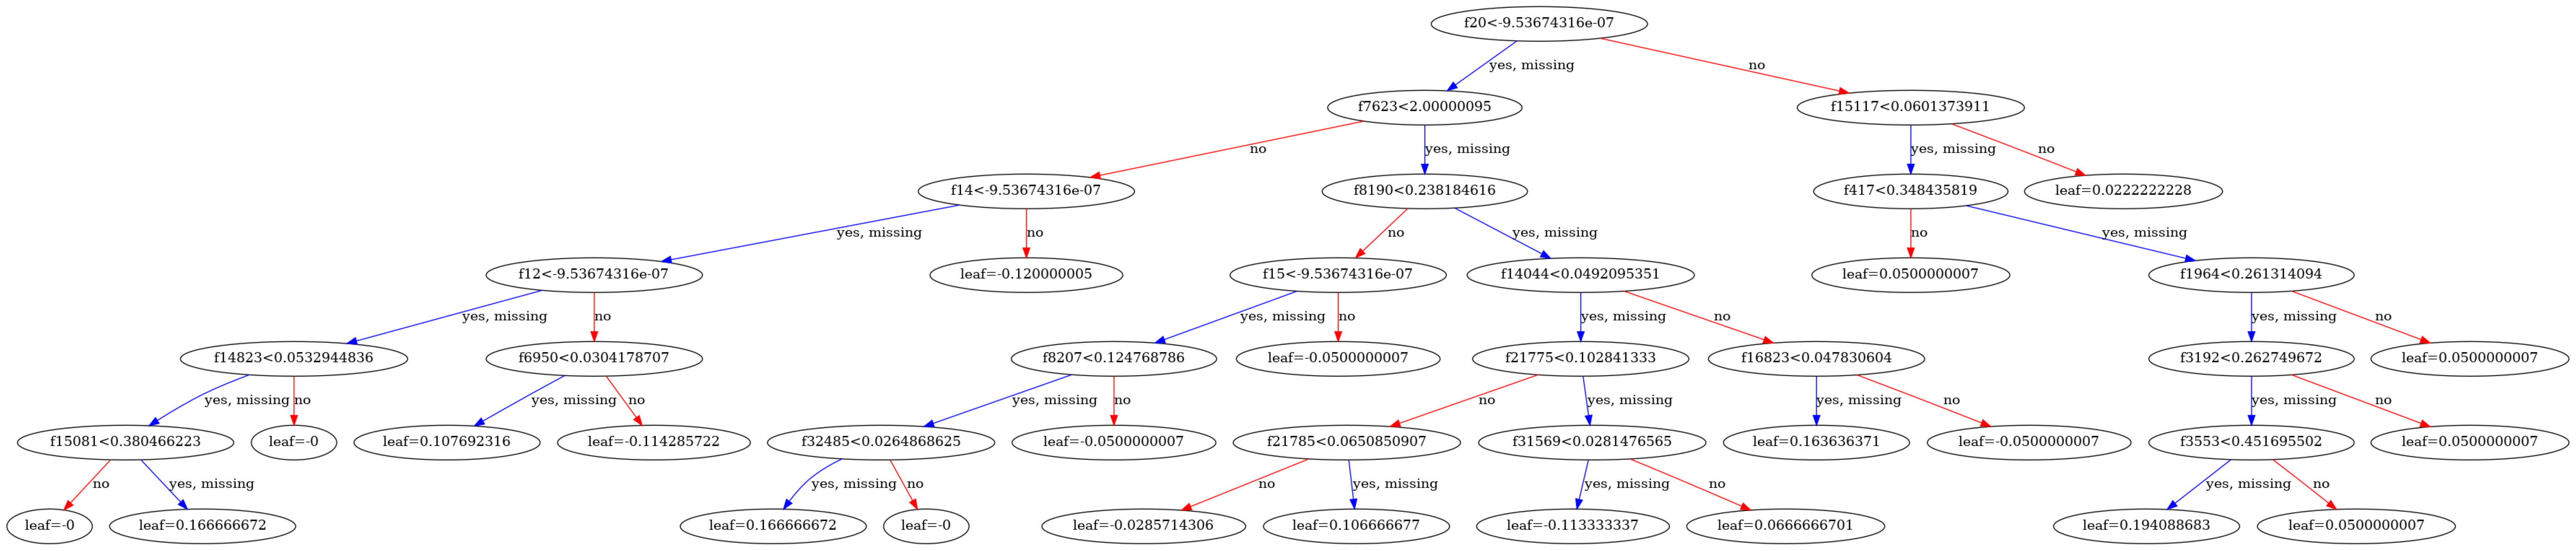

In [30]:
fig, ax = plt.subplots(figsize=(100, 100))
plot_tree(model,ax=ax)
plt.savefig('tree.png')

Pas très utile car on peut pas séléctionner le meilleur arbre.

### DecisionTree Classifier

In [31]:
param_grid =  {"decisiontreeclassifier__criterion": ["gini", "entropy"],
                "decisiontreeclassifier__max_depth": np.arange(2, 30, 1),
                "columntransformer__tfidfvectorizer-1__ngram_range": [(1,2)],
                "columntransformer__tfidfvectorizer-2__ngram_range": [(1,2)],
                "columntransformer__tfidfvectorizer-3__ngram_range": [(1,2)],
                "columntransformer__tfidfvectorizer-4__ngram_range": [(1,2)],
                   }

In [32]:
tree = DecisionTreeClassifier()

In [33]:
pipe = make_pipeline(columns_trans, tree)

In [34]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)

In [35]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['target_api',
                                                                          'categorie_juridique_label',
                                                                          'activite_principale_label']),
                                                                        ('tfidfvectorizer-1',
                                                                         TfidfVectorizer(ngram_range=(1,
                                                                                                      2)),
                                                                         'nom_raison_sociale'),
                   

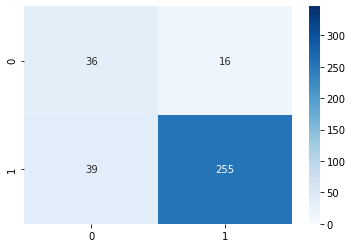

In [36]:
pred_tree = grid.predict(X_test)
confusion = confusion_matrix(y_test, pred_tree)
sns.heatmap(confusion, annot=True, vmin=0, vmax=len(y_test),cmap='Blues', fmt='g')
plt.show()

In [37]:
model= grid.best_estimator_.named_steps['decisiontreeclassifier']

In [38]:
from sklearn import tree

In [39]:
fig = plt.figure(figsize=(200,120))
tree.plot_tree(model,feature_names=feature_names,max_depth=2,filled=True,fontsize=80) 
fig.savefig('decision_tree.png')

## 2. API impot particulier sandbox

In [40]:
data_path = '../data_other/output_api_impot_particulier_sandbox.csv'

In [41]:
text_enc = TfidfVectorizer()
X,y,columns_trans = preprocess_data(data_path,text_enc)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [43]:
param_grid = {"randomforestclassifier__n_estimators": [100, 200, 400],
              "randomforestclassifier__max_depth": [4, 6, 8, 10, 12, 15],
              "randomforestclassifier__max_features": ["auto"],
              "randomforestclassifier__min_samples_split": [10],
              "randomforestclassifier__random_state": [64],
              "randomforestclassifier__class_weight": ['balanced', {0: .3, 1: .7},
                                                       {0: .4, 1: .6}],
                                              }

In [44]:
mod = RandomForestClassifier()

In [45]:
pipe = make_pipeline(columns_trans, mod)

In [46]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)

In [47]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['target_api',
                                                                          'categorie_juridique_label',
                                                                          'activite_principale_label']),
                                                                        ('tfidfvectorizer-1',
                                                                         TfidfVectorizer(),
                                                                         'nom_raison_sociale'),
                                                                        ('tfidfvectorizer-2',
                                             

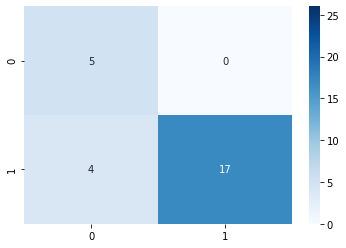

In [48]:
pred_forest = grid.predict(X_test)
confusion = confusion_matrix(y_test, pred_forest)
sns.heatmap(confusion, annot=True, vmin=0, vmax=len(y_test),cmap='Blues', fmt='g')
plt.show()

In [49]:
model= grid.best_estimator_.named_steps['randomforestclassifier']

In [50]:
pred_logreg=grid.predict(X_test)

In [51]:
list_proba_val = grid.predict_proba(X_test)[:,1].tolist()
list_proba_ref = grid.predict_proba(X_test)[:,0].tolist()
list_predicted_status = pred_logreg.tolist()

In [52]:
X_test['real_status'] =y_test

In [53]:
X_test['status_predicted'] = list_predicted_status
X_test['proba_validated'] = list_proba_val
X_test['proba_refused']= list_proba_ref

In [54]:
X_test = X_test[['status_predicted','proba_validated','proba_refused','real_status']]
X_test

,status_predicted,proba_validated,proba_refused,real_status
30,0,0.327724,0.672276,1
65,1,0.988232,0.011768,1
64,1,0.988232,0.011768,1
53,1,0.657122,0.342878,1
45,1,0.981402,0.018598,1
93,1,0.979382,0.020618,1
91,1,0.979382,0.020618,1
47,1,0.980558,0.019442,1
10,0,0.257647,0.742353,0
0,0,0.466259,0.533741,0
